In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
df_k1000 = pd.read_csv('../data/dataset/5.df_k1000_clustering.csv', index_col=0)
df_k1100 = pd.read_csv('../data/dataset/5.df_k1100_clustering.csv', index_col=0)

In [36]:
df_k1100['cluster'].max()

999

In [30]:
df_k1100['cluster'] = df_k1100['cluster'].astype('int') + 1000
df_k1100.head()

,cell_id,cluster,resident_table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust
0,87958702,1436,0,20220614,2,4146,용인시,41461256,이동읍,127.21692,37.18822,MALE,12,EV라운지,4,3.829
1,87958702,1436,0,20220629,3,4146,용인시,41461256,이동읍,127.21692,37.18822,MALE,12,EV라운지,4,3.829
2,87958702,1436,0,20220630,4,4146,용인시,41461256,이동읍,127.21692,37.18822,MALE,12,EV라운지,4,3.829
3,87958702,1436,0,20220616,4,4146,용인시,41461256,이동읍,127.21692,37.18822,MALE,12,EV Infra,5,3.829
4,87958702,1436,0,20220615,3,4146,용인시,41461256,이동읍,127.21692,37.18822,MALE,12,EV라운지,4,3.829


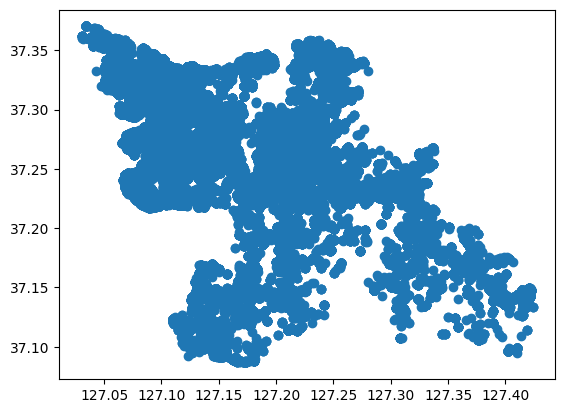

In [14]:
xcrds = df_k1000['cell_xcrd'].to_list()
ycrds = df_k1000['cell_ycrd'].to_list()

plt.scatter(xcrds, ycrds)
plt.show()

In [15]:
candidates = pd.concat([df_k1000, df_k1100], axis=0)
candidates

,cell_id,cluster,resident_table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust,0
0,87958702.0,436.0,0.0,20220614.0,2.0,4146.0,용인시,41461256.0,이동읍,127.21692,37.18822,MALE,12.0,EV라운지,4.0,3.829,NaN
1,87958702.0,436.0,0.0,20220629.0,3.0,4146.0,용인시,41461256.0,이동읍,127.21692,37.18822,MALE,12.0,EV라운지,4.0,3.829,NaN
2,87958702.0,436.0,0.0,20220630.0,4.0,4146.0,용인시,41461256.0,이동읍,127.21692,37.18822,MALE,12.0,EV라운지,4.0,3.829,NaN
3,87958702.0,436.0,0.0,20220616.0,4.0,4146.0,용인시,41461256.0,이동읍,127.21692,37.18822,MALE,12.0,EV Infra,5.0,3.829,NaN
4,87958702.0,436.0,0.0,20220615.0,3.0,4146.0,용인시,41461256.0,이동읍,127.21692,37.18822,MALE,12.0,EV라운지,4.0,3.829,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1209.0
456674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1171.0
456675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1557.0
456676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1318.0
